## Imports

In [1]:
import pandas as pd
import pickle
import spacy
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import hist
import tensorflow as tf

## Loading Data

In [2]:
ekg_denoised = pd.read_pickle('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised_v2.pkl')
ekg_denoised = ekg_denoised.sample(frac=1)

In [3]:
ekg_denoised.head()

,ICD9_CODE,TEXT
18387,0,normal sinus rhythm. marked t wave inversions ...
56170,2,underlying atrial flutter with group ventricul...
28037,0,sinus rhythm. within normal limits. no previou...
59437,2,baseline artifact. ventricular paced rhythm. a...
7829,3,sinus rhythm probable normal ecg since previou...


## Spacy

#### Downloading and Loading Spacy Embeddings

In [1]:
#!python -m spacy download en_core_web_md

2021-11-17 00:38:48.868995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 00:38:48.869188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 45.7 MB 64 kB/s             
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
nlp = spacy.load('en_core_web_md')

#### Testing Spacy Embeddings

In [6]:
doc = nlp("sinus rhythm. compared to tracing 1 no diagnostic interim change. tracing 2")
print(doc.vector.shape)
doc.vector

(300,)


array([-5.00825867e-02,  2.34442070e-01, -1.47236139e-01,  1.79825034e-02,
       -3.41885015e-02, -5.65572195e-02,  9.41328239e-03, -4.99943532e-02,
        1.39321953e-01,  1.65153766e+00, -1.48617715e-01,  2.31521294e-01,
        8.35297704e-02,  1.76000714e-01,  1.16957293e-03, -5.54402284e-02,
        1.99811742e-01,  1.40888703e+00, -9.33964252e-02, -5.83115034e-02,
        3.43884304e-02,  3.40443780e-03, -2.34556273e-01, -1.05062291e-01,
       -8.92671105e-03,  1.92777123e-02, -8.44067335e-03,  1.91751588e-02,
        1.34894580e-01,  8.49958584e-02,  4.53957133e-02,  7.32796043e-02,
       -1.18446406e-02, -1.36181086e-01,  7.27292076e-02,  1.67326778e-01,
        1.02550071e-02,  8.56276304e-02,  6.58611134e-02, -6.31382093e-02,
        2.15512812e-02, -7.76198581e-02,  7.92574957e-02, -2.48679277e-02,
       -3.74911427e-02, -1.35982186e-01, -9.75067765e-02,  1.94221720e-01,
       -1.74879972e-02,  3.41023579e-02, -1.35499965e-02, -3.56617868e-02,
        9.32188630e-02, -

### Running Spacy on dataset

In [5]:
docs = list(nlp.pipe(ekg_denoised.TEXT))

#### Making embeddings for feed forward neural network (300x1)

In [9]:
spacy_embeddings = []
for i in docs:
    spacy_embeddings.append(i.vector)

In [10]:
ekg_denoised['spacy_embeddings'] = spacy_embeddings

In [11]:
ekg_denoised.drop(columns='TEXT', inplace = True)

In [12]:
ekg_denoised.spacy_embeddings[4404].shape

(300,)

In [13]:
ekg_denoised.to_pickle('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised_spacy_v2.pkl')


#### Making Embeddings for RNN (Samples x Num Words x 300)

In [6]:
doc_embeddings = []
for note in docs:
    word_embeddings = []
    for words in note:
        word_embeddings.append(np.array(words.vector, dtype=np.float))
    doc_embeddings.append(np.array(word_embeddings))

In [7]:
lengths = []
for i in doc_embeddings:
    lengths.append(len(i))

In [8]:
max(lengths)

202

(array([1.4146e+04, 3.2675e+04, 1.5524e+04, 4.4830e+03, 1.0320e+03,
        2.3500e+02, 6.4000e+01, 1.3000e+01, 6.0000e+00, 2.0000e+00]),
 array([  1. ,  21.1,  41.2,  61.3,  81.4, 101.5, 121.6, 141.7, 161.8,
        181.9, 202. ]),
 <BarContainer object of 10 artists>)

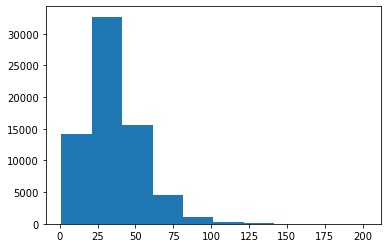

In [9]:
hist(lengths)

Need to pad to make sure all vectors are the same length (max length of vectors)

In [13]:
zeros_index = []
for i in range (len(doc_embeddings)):
    if doc_embeddings[i].shape[0] == 0:
        zeros_index.append(i)
    else:
        while doc_embeddings[i].shape[0] < max(lengths):
            doc_embeddings[i]=np.append(doc_embeddings[i], [np.zeros(300,)], axis = 0)

In [13]:
len(doc_embeddings)

68180

In [14]:
zeros_index

[]

In [17]:
for i in zeros_index:
    doc_embeddings.pop(i)
    doc_labels_np = np.delete(np.array(ekg_denoised['ICD9_CODE']), i, 0)

In [17]:
doc_labels_np = np.array(ekg_denoised['ICD9_CODE'])

In [15]:
doc_embeddings_np = np.array(doc_embeddings)

In [18]:
len(doc_labels_np) == len(doc_embeddings_np)

True

In [19]:
np.save('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised_spacy_RNN_embeddings_v2',
        doc_embeddings_np,
        allow_pickle=True)
    
np.save('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised_spacy_RNN_values_v2',
        doc_labels_np,
        allow_pickle=True)